In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import fcwt

In [2]:
def fcwtplotter(audio_data,sample_rate,f0,f1):
    #make sure signal is a numpy float array
    audio_data = np.array(audio_data, dtype=np.float32)
    audio_data -= np.mean(audio_data)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max_val = np.max(np.abs(audio_data))
    if max_val > 0:
        signal = audio_data / max_val


    fn = 100

    fcwt.plot(signal, sample_rate, f0=f0, f1=f1, fn=fn)


In [17]:
len(detrended2)

247

In [18]:
300/247


1.214574898785425

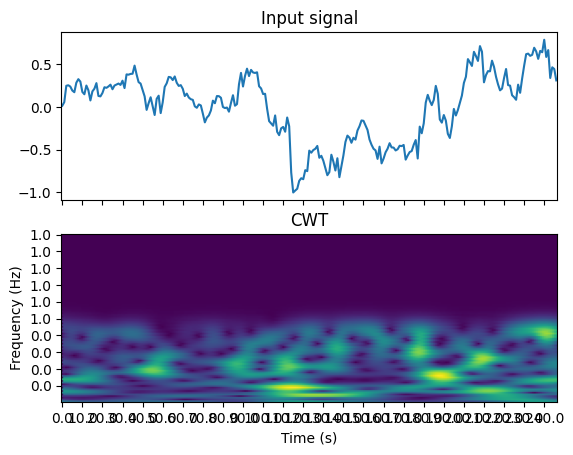

In [24]:
fcwtplotter(detrended2,1,.1,1)

In [14]:
def cwt(signal,high,low,sample_rate,nfreqs):
    #make sure signal is a numpy float array
    signal = np.array(signal, dtype=np.float32)
    signal -= np.mean(signal)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max_val = np.max(np.abs(signal))
    if max_val > 0:
        signal = signal / max_val
    print(signal.shape,sample_rate,low,high,nfreqs)
    return fcwt.cwt(signal,sample_rate,low,high,nfreqs)

In [15]:
cwt(detrended2,1,.1,1,300)

(250,) 1 0.1 1 300


(array([0.99700004, 0.9940001 , 0.991     , 0.988     , 0.985     ,
        0.98200005, 0.97900003, 0.976     , 0.97300005, 0.97      ,
        0.967     , 0.96400005, 0.9610001 , 0.958     , 0.9550001 ,
        0.952     , 0.94900006, 0.94600004, 0.9430001 , 0.94      ,
        0.93700004, 0.934     , 0.931     , 0.92800003, 0.925     ,
        0.92200005, 0.91899997, 0.916     , 0.91300005, 0.91      ,
        0.907     , 0.90400004, 0.90099996, 0.898     , 0.89500004,
        0.892     , 0.88900006, 0.8860001 , 0.883     , 0.8800001 ,
        0.87700003, 0.87399995, 0.8710001 , 0.868     , 0.86499995,
        0.86200005, 0.859     , 0.85599995, 0.85300004, 0.85      ,
        0.84699994, 0.844     , 0.8410001 , 0.8380001 , 0.83500004,
        0.832     , 0.8290001 , 0.82600003, 0.823     , 0.82000005,
        0.81700003, 0.814     , 0.81100005, 0.808     , 0.805     ,
        0.80200005, 0.799     , 0.796     , 0.79300004, 0.79      ,
        0.787     , 0.784     , 0.781     , 0.77

In [8]:
# old functions coherence and plotter
import numpy as np
from pycwt import wct
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.io.wavfile as wav
# Compute the wavelet coherence
def wavelet_coherence_old(signal1,signal2,highest,lowest,nfreqs):
    frame_rate = 1
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,)
    freqs, coeffs2 = fcwt.cwt(signal2,frame_rate,lowest,highest,nfreqs,nthreads = 4,)

    # Compute coherence
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)
    
    # Smooth spectra and cross-spectrum
    def smooth(data, sigma=(2,2), mode='nearest'):
        #return data
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smoothed = smooth(S1)
    S2_smoothed = smooth(S2)
    S12_smoothed = smooth(np.abs(S12) ** 2)

    # Coherence calculation
    coherence = S12_smoothed / (((S1_smoothed) **2) * ((S2_smoothed)**2))
    coherence = S12_smoothed / (np.sqrt(S1_smoothed) * np.sqrt(S2_smoothed))
    #coherence = np.clip(coherence, 0.0, 1.0)  # Limit coherence to [0, 1]

    return coherence, freqs, [coeffs1,coeffs2], S12

def coherence_plot_old(coherence,freqs,rate):
    extent=[0, len(coherence),len(freqs) ,0]

    coherence = np.where(coherence<.1,0,coherence)
    max1 = np.max(np.abs(coherence))
    min1 = np.min(np.abs(coherence))
    coherence = (coherence-min1) / (max1-min1)
    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
        
    if True:
        plt.figure(figsize=(10,6))
        plt.imshow(coherence, aspect='auto',extent=extent,cmap = 'jet')
        plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values],fontsize = 14)
        plt.xticks(np.linspace(0, len(coherence), 5),fontsize = 14)

        plt.ylabel('Scale (Frequency)',fontsize = 18)
        plt.xlabel('Time (Days)',fontsize = 18)
        plt.title(f'Wavelet Coherence Between signal1 and signal2',fontsize=20)
        plt.show()

coh,freqs,coeffs,S12 = wavelet_coherence_old(detrended,detrended2,0.5,0.001,200)


In [3]:
# pull data from polygon
import datetime
import numpy as np
from scipy.signal import detrend
import requests

def pull_data(ticker, api_key):
    """
    Pull and detrend stock data from the past 5 hours using Polygon.io.

    Parameters:
    ticker (str): Stock ticker symbol.
    api_key (str): Your Polygon.io API key.

    Returns:
    times (array): Array of timestamps.
    close (array): Closing prices.
    detrended_close (array): Detrended closing prices.
    stock_data (DataFrame): Raw stock data from Polygon.
    """
    # Define the date range
    end_datetime = datetime.datetime.now()
    start_datetime = end_datetime - datetime.timedelta(days = 365)

    # Convert to timestamp format for Polygon API
    start_timestamp = int(start_datetime.timestamp()) * 1000
    end_timestamp = int(end_datetime.timestamp()) * 1000

    # Polygon API endpoint for aggregate bars
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_datetime.date()}/{end_datetime.date()}?adjusted=true&apiKey={api_key}"
    
    # Fetch the data
    response = requests.get(url)
    data = response.json()

    if 'results' not in data:
        raise ValueError(f"Error fetching data: {data}")

    # Convert data to arrays
    times = np.array([entry['t'] for entry in data['results']])  # Timestamps
    close = np.array([entry['c'] for entry in data['results']])  # Closing prices

    # Detrend closing prices
    detrended_close = detrend(close)

    return times, close, detrended_close, data


In [4]:
# Example usage:
key = 'jjeryxeZXNkBhTEQF0SDj8uBBI_N1dBM'	
ticker = 'AAPL'
_,close,detrended,df= pull_data(ticker,key)
_,close2,detrended2,df2= pull_data('AMZN',key)

In [194]:
len(detrended2)

250

C:\Users\E7450\AppData\Local\Temp\ipykernel_1704\1218349509.py:6: RuntimeWarning: divide by zero encountered in divide
  coi_freq = 1.0 / coi_width


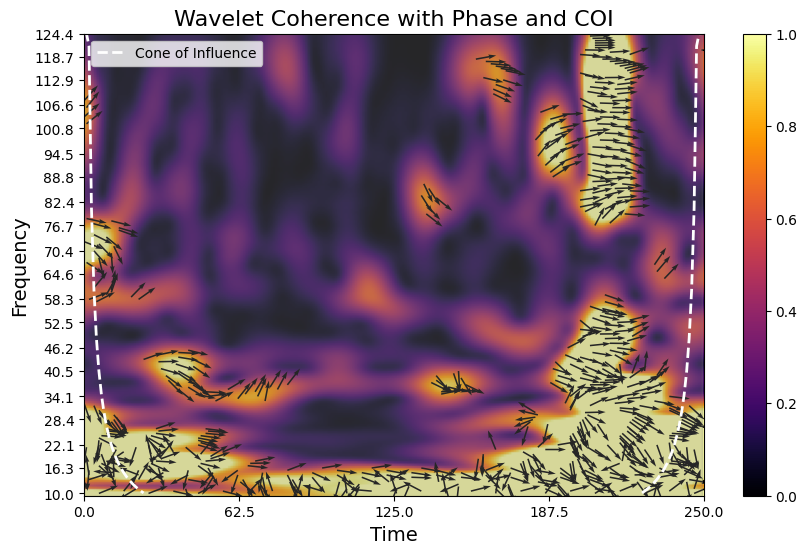

In [204]:
coh,freqs,coeffs,S12 = wavelet_coherence_old(detrended,detrended2,125,10,200)
_ = coherence_plot_with_arrows(coh, freqs, S12)

C:\Users\E7450\AppData\Local\Temp\ipykernel_1704\1218349509.py:6: RuntimeWarning: divide by zero encountered in divide
  coi_freq = 1.0 / coi_width


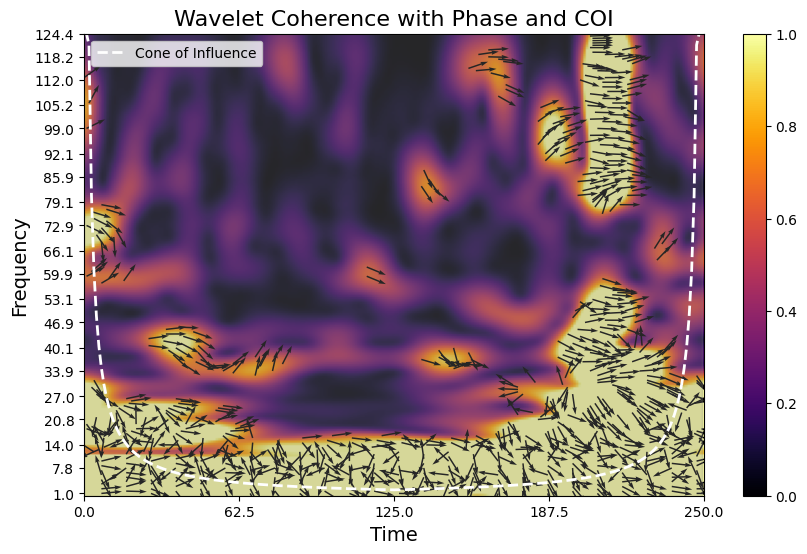

In [ ]:
def coherence_plot_with_arrows(coherence, freqs, S12):
    extent = [0, coherence.shape[1], len(freqs), 0]

    # Normalize coherence for color map
    coherence = np.clip(coherence, 0, 3)
    norm_coh = (coherence - coherence.min()) / (coherence.max() - coherence.min())

    # Phase angle and vectors
    phase = np.angle(S12)
    U = np.cos(phase)
    V = np.sin(phase)

    # Coordinate grid
    X, Y = np.meshgrid(np.arange(coherence.shape[1]), np.arange(coherence.shape[0]))

    # Mask: only take high-coherence regions
    mask = norm_coh > 0.6
    indices = np.argwhere(mask)

    # Subsample: take every nth index from the masked points
    subsample_rate = 20
    subsampled_indices = indices[::subsample_rate]

    x_sub = [X[i, j] for i, j in subsampled_indices]
    y_sub = [Y[i, j] for i, j in subsampled_indices]
    u_sub = [U[i, j] for i, j in subsampled_indices]
    v_sub = [V[i, j] for i, j in subsampled_indices]

    # Frequency ticks
    y_values = np.linspace(freqs[0], freqs[-1], len(freqs))
    subsampled_y_ticks = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_labels = [f"{y_values[i]:.1f}" for i in subsampled_y_ticks]

    # Plot coherence
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(norm_coh, aspect='auto', extent=extent, cmap='inferno')
    ax.quiver(x_sub, y_sub, u_sub, v_sub, color='black', scale=30, headwidth=3)

    dt = 1 / 250
    fourier_factor = 1.03
    coi_freq = compute_coi(freqs, coh.shape[1], dt=dt, fourier_factor=fourier_factor)
    coi_y = freq_to_img_y(coi_freq, freqs)
    # --- Cone of Influence (COI) ---
    n_time = coherence.shape[1]
    dt = 1
    fourier_factor = 1.5  # Morlet approximation

    coi = fourier_factor * dt * np.concatenate([
        np.arange(1, n_time // 2 + 1),
        np.arange(n_time // 2, 0, -1)
    ])
    #coi_freq = 1 / coi
    #coi_freq = np.clip(coi_freq, freqs[0], freqs[-1])

    # Map frequencies to imshow Y-coordinates (image row indices)
    # Remember: imshow y=0 is freqs[-1], y=len(freqs) is freqs[0]
    #freq_to_y = np.interp(coi_freq, freqs[::-1], np.linspace(0, len(freqs), len(freqs)))
    

    ax.plot(np.arange(n_time), coi_y, 'w--', linewidth=2, label='Cone of Influence')
    ax.fill_between(np.arange(n_time), len(freqs), freq_to_y, color='gray', alpha=0.3)


    # Axes labels and ticks
    ax.set_yticks(subsampled_y_ticks)
    ax.set_yticklabels(subsampled_y_labels)
    ax.set_xticks(np.linspace(0, coherence.shape[1], 5))
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_xlabel('Time', fontsize=14)
    ax.set_title('Wavelet Coherence', fontsize=16)
    fig.colorbar(im, ax=ax)
    ax.legend()

    return fig,freq_to_y,coi_freq

_,freq_to_y,coi_freq = coherence_plot_with_arrows(coh, freqs, S12)

C:\Users\E7450\AppData\Local\Temp\ipykernel_1704\1218349509.py:6: RuntimeWarning: divide by zero encountered in divide
  coi_freq = 1.0 / coi_width


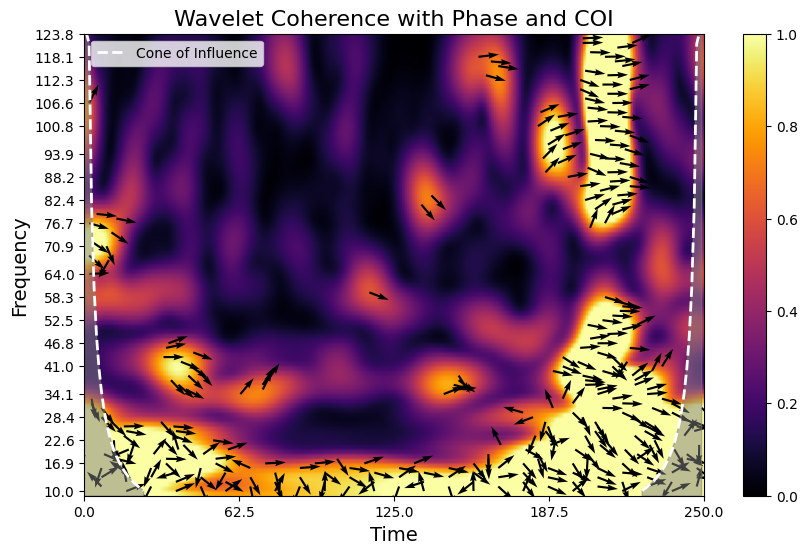

In [220]:
# old functions coherence and plotter
import numpy as np
from pycwt import wct
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.io.wavfile as wav
# Compute the wavelet coherence
def wavelet_coherence_old(signal1,signal2,highest,lowest,nfreqs):
    frame_rate = 250
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,)
    freqs, coeffs2 = fcwt.cwt(signal2,frame_rate,lowest,highest,nfreqs,nthreads = 4,)

    # Compute coherence
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)
    
    # Smooth spectra and cross-spectrum
    def smooth(data, sigma=(2,2), mode='nearest'):
        #return data
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smoothed = smooth(S1)
    S2_smoothed = smooth(S2)
    S12_smoothed = smooth(np.abs(S12) ** 2)

    # Coherence calculation
    coherence = S12_smoothed / (((S1_smoothed) **2) * ((S2_smoothed)**2))
    coherence = S12_smoothed / (np.sqrt(S1_smoothed) * np.sqrt(S2_smoothed))
    #coherence = np.clip(coherence, 0.0, 1.0)  # Limit coherence to [0, 1]

    return coherence, freqs, [coeffs1,coeffs2], S12

def coherence_plot_old(coherence,freqs,rate):
    extent=[0, len(coherence),len(freqs) ,0]

    coherence = np.where(coherence<.1,0,coherence)
    max1 = np.max(np.abs(coherence))
    min1 = np.min(np.abs(coherence))
    coherence = (coherence-min1) / (max1-min1)
    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
        
    if True:
        plt.figure(figsize=(10,6))
        plt.imshow(coherence, aspect='auto',extent=extent,cmap = 'jet')
        plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values],fontsize = 14)
        plt.xticks(np.linspace(0, len(coherence), 5),fontsize = 14)

        plt.ylabel('Scale (Frequency)',fontsize = 18)
        plt.xlabel('Time (Days)',fontsize = 18)
        plt.title(f'Wavelet Coherence Between signal1 and signal2',fontsize=20)
        plt.show()

def coherence_plot_with_arrows(coherence, freqs, S12):
    extent = [0, coherence.shape[1], len(freqs), 0]

    # Normalize coherence for color map
    coherence = np.clip(coherence, 0, 3)
    norm_coh = (coherence - coherence.min()) / (coherence.max() - coherence.min())

    # Phase angle and vectors
    phase = np.angle(S12)
    U = np.cos(phase)
    V = np.sin(phase)

    # Coordinate grid
    X, Y = np.meshgrid(np.arange(coherence.shape[1]), np.arange(coherence.shape[0]))

    # Mask: only take high-coherence regions
    mask = norm_coh > 0.6
    indices = np.argwhere(mask)

    # Subsample: take every nth index from the masked points
    subsample_rate = 20
    subsampled_indices = indices[::subsample_rate]

    x_sub = [X[i, j] for i, j in subsampled_indices]
    y_sub = [Y[i, j] for i, j in subsampled_indices]
    u_sub = [U[i, j] for i, j in subsampled_indices]
    v_sub = [V[i, j] for i, j in subsampled_indices]

    # Frequency ticks
    y_values = np.linspace(freqs[0], freqs[-1], len(freqs))
    subsampled_y_ticks = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_labels = [f"{y_values[i]:.1f}" for i in subsampled_y_ticks]

    # Plot coherence
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(norm_coh, aspect='auto', extent=extent, cmap='inferno')
    ax.quiver(x_sub, y_sub, u_sub, v_sub, color='black', scale=30, headwidth=3)

    dt = 1 / 250
    fourier_factor = 1.03
    coi_freq = compute_coi(freqs, coh.shape[1], dt=dt, fourier_factor=fourier_factor)
    coi_y = freq_to_img_y(coi_freq, freqs)
    # --- Cone of Influence (COI) ---
    n_time = coherence.shape[1]
    dt = 1
    fourier_factor = 1.5  # Morlet approximation

    coi = fourier_factor * dt * np.concatenate([
        np.arange(1, n_time // 2 + 1),
        np.arange(n_time // 2, 0, -1)
    ])
    #coi_freq = 1 / coi
    #coi_freq = np.clip(coi_freq, freqs[0], freqs[-1])

    # Map frequencies to imshow Y-coordinates (image row indices)
    # Remember: imshow y=0 is freqs[-1], y=len(freqs) is freqs[0]
    #freq_to_y = np.interp(coi_freq, freqs[::-1], np.linspace(0, len(freqs), len(freqs)))
    

    ax.plot(np.arange(n_time), coi_y, 'w--', linewidth=2, label='Cone of Influence')
    ax.fill_between(np.arange(n_time), len(freqs), coi_y, color='gray', alpha=0.5)


    # Axes labels and ticks
    ax.set_yticks(subsampled_y_ticks)
    ax.set_yticklabels(subsampled_y_labels)
    ax.set_xticks(np.linspace(0, coherence.shape[1], 5))
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_xlabel('Time', fontsize=14)
    ax.set_title('Wavelet Coherence with Phase and COI', fontsize=16)
    fig.colorbar(im, ax=ax)
    ax.legend()

    return fig,freq_to_y,coi_freq

#_,freq_to_y,coi_freq = coherence_plot_with_arrows(coh, freqs, S12)

coh,freqs,coeffs,S12 = wavelet_coherence_old(detrended,detrended2,125,10,100)
_ = coherence_plot_with_arrows(coh, freqs, S12)


C:\Users\E7450\AppData\Local\Temp\ipykernel_1704\1218349509.py:6: RuntimeWarning: divide by zero encountered in divide
  coi_freq = 1.0 / coi_width


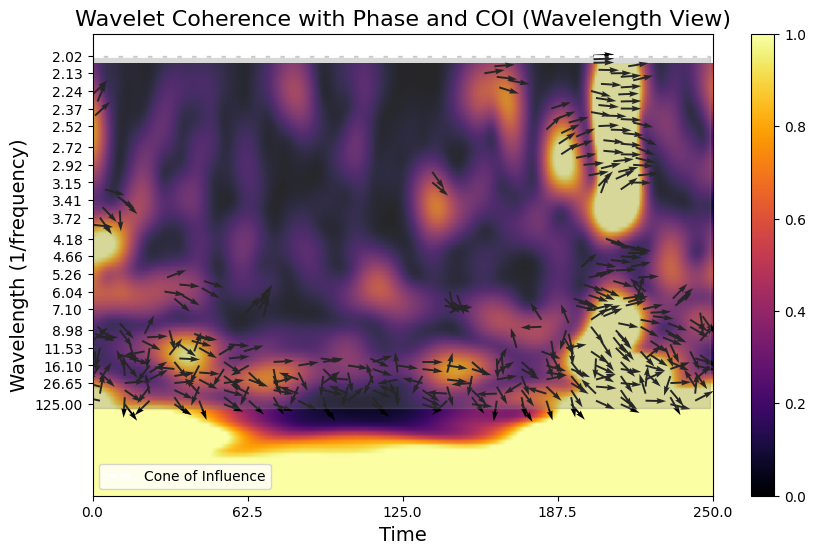

In [230]:
def wavelet_coherence_wavelength(signal1, signal2, min_wavelength, max_wavelength, nfreqs, frame_rate=1):
    """
    Compute wavelet coherence using wavelength (1/frequency) as the input.
    
    Args:
        signal1 (np.array): First input signal.
        signal2 (np.array): Second input signal.
        min_wavelength (float): Longest scale (i.e., lowest frequency) in time units.
        max_wavelength (float): Shortest scale (i.e., highest frequency) in time units.
        nfreqs (int): Number of frequencies/wavelengths to compute.
        frame_rate (int): Sampling rate of the signals.

    Returns:
        coherence (np.array): Coherence matrix.
        wavelengths (np.array): Corresponding wavelengths.
        coeffs (list): Wavelet coefficients of both signals.
        S12 (np.array): Cross-spectrum.
    """
    # Convert wavelength to frequency
    lowest_freq = 1.0 / max_wavelength
    highest_freq = 1.0 / min_wavelength

    # Get coefficients
    freqs, coeffs1 = fcwt.cwt(signal1, frame_rate, lowest_freq, highest_freq, nfreqs, nthreads=4)
    freqs, coeffs2 = fcwt.cwt(signal2, frame_rate, lowest_freq, highest_freq, nfreqs, nthreads=4)

    # Compute spectra and cross-spectrum
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)

    # Smooth
    def smooth(data, sigma=(2, 2), mode='nearest'):
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smoothed = smooth(S1)
    S2_smoothed = smooth(S2)
    S12_smoothed = smooth(np.abs(S12) ** 2)

    # Compute coherence
    coherence = S12_smoothed / (np.sqrt(S1_smoothed) * np.sqrt(S2_smoothed))

    # Convert frequencies to wavelengths
    wavelengths = 1.0 / freqs

    return coherence,freqs, [coeffs1, coeffs2], S12


def coherence_plot_with_wavelengths(coherence, freqs, S12):
    wavelengths = 1 / freqs

    extent = [0, coherence.shape[1], wavelengths[-1], wavelengths[0]]  # wavelength range (inverted: low to high)

    # Normalize coherence for color map
    coherence = np.clip(coherence, 0, 3)
    norm_coh = (coherence - coherence.min()) / (coherence.max() - coherence.min())

    # Phase angle and vectors
    phase = np.angle(S12)
    U = np.cos(phase)
    V = np.sin(phase)

    # Coordinate grid
    X, Y = np.meshgrid(np.arange(coherence.shape[1]), np.arange(coherence.shape[0]))

    # Mask: only take high-coherence regions
    mask = norm_coh > 0.6
    indices = np.argwhere(mask)

    # Subsample phase arrows
    subsample_rate = 20
    subsampled_indices = indices[::subsample_rate]
    x_sub = [X[i, j] for i, j in subsampled_indices]
    y_sub = [Y[i, j] for i, j in subsampled_indices]
    u_sub = [U[i, j] for i, j in subsampled_indices]
    v_sub = [V[i, j] for i, j in subsampled_indices]

    # Convert frequencies to wavelengths
    wavelengths = 1 / freqs
    y_values = wavelengths
    subsampled_y_ticks = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_labels = [f"{y_values[i]:.2f}" for i in subsampled_y_ticks]
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(norm_coh, aspect='auto', extent=extent, cmap='inferno', origin='upper')
    ax.quiver(x_sub, y_sub, u_sub, v_sub, color='black', scale=30, headwidth=3)

    # --- COI calculation ---
    n_time = coherence.shape[1]
    dt = 1 / 250  # adjust for your data
    fourier_factor = 1.5
    coi_freq = compute_coi(freqs, n_time, dt=dt, fourier_factor=fourier_factor)
    coi_wavelength = 1 / coi_freq
    coi_y = np.interp(coi_wavelength, wavelengths[::-1], np.linspace(0, len(freqs) - 1, len(freqs)))

    ax.plot(np.arange(n_time), coi_y, 'w--', linewidth=2, label='Cone of Influence')
    ax.fill_between(np.arange(n_time), len(freqs), coi_y, color='gray', alpha=0.3)

    # Axes labels
    ax.set_yticks(subsampled_y_ticks)
    ax.set_yticklabels(subsampled_y_labels)
    ax.set_xticks(np.linspace(0, coherence.shape[1], 5))
    ax.set_ylabel('Wavelength (1/frequency)', fontsize=14)
    ax.set_xlabel('Time', fontsize=14)
    ax.set_title('Wavelet Coherence with Phase and COI (Wavelength View)', fontsize=16)
    fig.colorbar(im, ax=ax)
    ax.legend()

    return fig, coi_y, coi_wavelength

#coh,freqs,coeffs,S12 = wavelet_coherence_old(detrended,detrended2,125,10,200)
#_ = coherence_plot_with_arrows(coh, freqs, S12)

coh,freqs,coeffs,S12 = wavelet_coherence_wavelength(detrended,detrended2,2,125,100)
_ = coherence_plot_with_wavelengths(coh, freqs, S12)


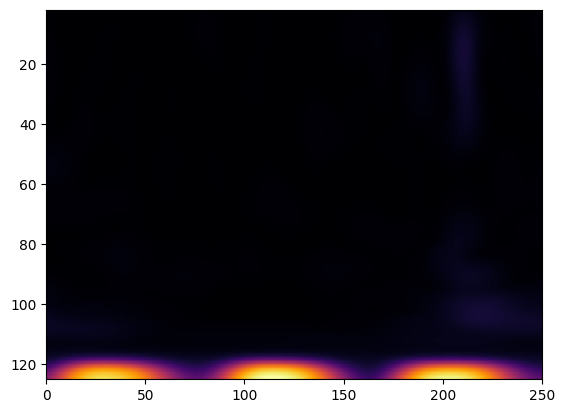

In [231]:
wavelengths = 1/freqs
extent = [0, coh.shape[1], wavelengths[-1], wavelengths[0]]  # wavelength range (inverted: low to high)

plt.imshow(coh, aspect='auto', extent=extent, cmap='inferno', origin='upper')
